# Rough Models Calibration Demo

*This notebook shows how to calibrate two rough volatility models:*

- **rBergomi** — parameters: *(H, η, ρ, ξ₀)*.
- **Rough Heston** — parameters: *(v₀, κ, θ, η, ρ, H)*.

**We’ll do:**
1. Load helpers and define a robust implied-vol wrapper (handles dividend yield `q`).
2. Build a sample smile (you can replace with your market data).
3. Calibrate **rBergomi** in IV space (vega-weighted).
4. Calibrate **Rough Heston** in price space with optional ATM/skew penalties.
5. Visualize model vs market prices and IVs + residuals.
6. (Optional) Coarse→Refine two-stage calibration for speed & robustness.


In [28]:
# --- imports & path ---
import os, sys, math, json, time, hashlib
import numpy as np
from matplotlib import cm, colors, rcParams
rcParams['font.family'] = 'Times New Roman'
import matplotlib.pyplot as plt
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)

from src.black_scholes import black_scholes_price
from src.volatility import implied_volatility
from src.heston import heston_price
from src.rough import rbergomi_paths
from src.rough import rough_heston_paths
from src.calibration import calibrate_rbergomi, calibrate_rough_heston

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# --- IV helpers ---
def implied_vol_q(price, S, K, T, r, q, option_type="call"):
    Seff = S * math.exp(-q*T)
    reff = r - q
    return implied_volatility(price, Seff, K, T, reff, option_type=option_type)

def prices_to_ivs(S, r, q, T, strikes, prices, option_type="call"):
    ivs = []
    for K, p in zip(strikes, prices):
        try:
            ivs.append(implied_vol_q(p, S, K, T, r, q, option_type))
        except Exception:
            ivs.append(np.nan)
    return np.array(ivs, float)

import os
WORKERS = min(12, os.cpu_count() or 12)
PAR_BACKEND = "thread"
TERMINAL_ONLY = True


## Calibration Caching (Save/Load)

We create a content hash of:
* the **smile** (S0, r, q, T, strikes, mids, cp)
* the **model name** ("rbergomi" or "rough_heston")
* the **metric** (price | iv), **vega_weight** flag
* **MC controls** (N, paths, fgn_method/batch_size)
* **bounds** and **initial guess** (x0)
* the **seed**

Then we save results to `../cache/<model>/<hash>.json`.

Re-running with the same inputs hits the cache and returns in milliseconds.


In [29]:
# --- JSON cache (thin wrapper using src.calibration.calibrate_cached)
try:
    from src.calibration import calibrate_cached
except (ImportError, AttributeError):
    import importlib, src.rough as _rough
    importlib.reload(_rough)
    import src.calibration as _cal
    _cal = importlib.reload(_cal)
    calibrate_cached = _cal.calibrate_cached
CACHE_DIR = os.path.abspath(os.path.join(repo_root, "cache"))
os.makedirs(CACHE_DIR, exist_ok=True)

def calibrate_rbergomi_cached(smiles, metric, vega_weight, x0, mc, seed=1234, bounds=None, multistart=2, options=None):
    overrides = dict(n_workers=WORKERS, parallel_backend=PAR_BACKEND, terminal_only=TERMINAL_ONLY)
    return calibrate_cached("rbergomi", calibrate_rbergomi, smiles=smiles, metric=metric, vega_weight=vega_weight, x0=x0, mc=mc, seed=seed, bounds=bounds, multistart=multistart, options=options, cache_dir=CACHE_DIR, runtime_overrides=overrides)

def calibrate_rough_heston_cached(smiles, metric, vega_weight, x0, mc, seed=7777, bounds=None, multistart=2, options=None):
    overrides = dict(n_workers=WORKERS, parallel_backend=PAR_BACKEND, terminal_only=TERMINAL_ONLY)
    return calibrate_cached("rough_heston", calibrate_rough_heston, smiles=smiles, metric=metric, vega_weight=vega_weight, x0=x0, mc=mc, seed=seed, bounds=bounds, multistart=multistart, options=options, cache_dir=CACHE_DIR, runtime_overrides=overrides)


## Sample Smile (You can replace with market data)

*Replace the arrays below with your own strikes & mid prices per maturity.*
*You can also add more maturities by appending to `smiles` a tuple `(S0, r, q, T, strikes, mids, "call" or "put")`.*


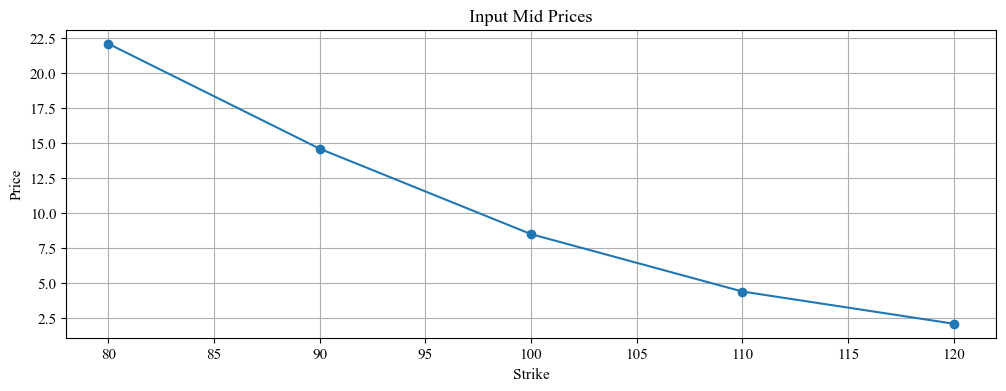

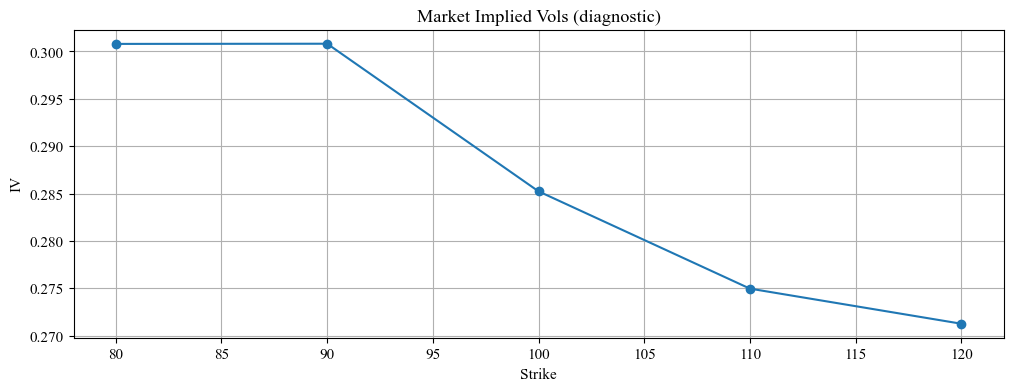

In [30]:
# Basic market setup
S0 = 100.0
r, q = 0.02, 0.00   # set your dividend yield here
T  = 0.50

# A flat-ish example smile (replace with your own)
strikes = np.array([80, 90, 100, 110, 120], float)
mids    = np.array([22.10, 14.60,  8.50,  4.40,  2.10], float)

cp = "call"
smiles = [(S0, r, q, T, strikes, mids, cp)]

# Plot the raw mid prices
plt.figure()
plt.plot(strikes, mids, marker="o")
plt.title("Input Mid Prices")
plt.xlabel("Strike")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Convert to market IVs (diagnostic)
mkt_iv = prices_to_ivs(S0, r, q, T, strikes, mids, option_type=cp)
plt.figure()
plt.plot(strikes, mkt_iv, marker="o")
plt.title("Market Implied Vols (diagnostic)")
plt.xlabel("Strike")
plt.ylabel("IV")
plt.grid(True)
plt.show()


## Real market data

Available expiries: ('2025-10-17', '2025-10-24', '2025-10-31', '2025-11-07', '2025-11-14', '2025-11-21', '2025-11-28', '2025-12-19', '2026-01-16', '2026-02-20') ...
Chosen expiry: 2026-04-17
S0=249.3400, T=0.5014y, DF=1.011049, r=-2.1916%, F=253.4262, q=-5.4338%


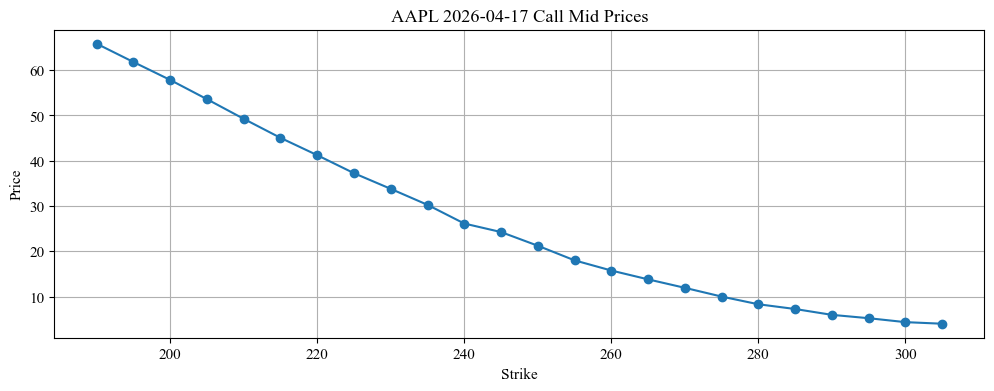

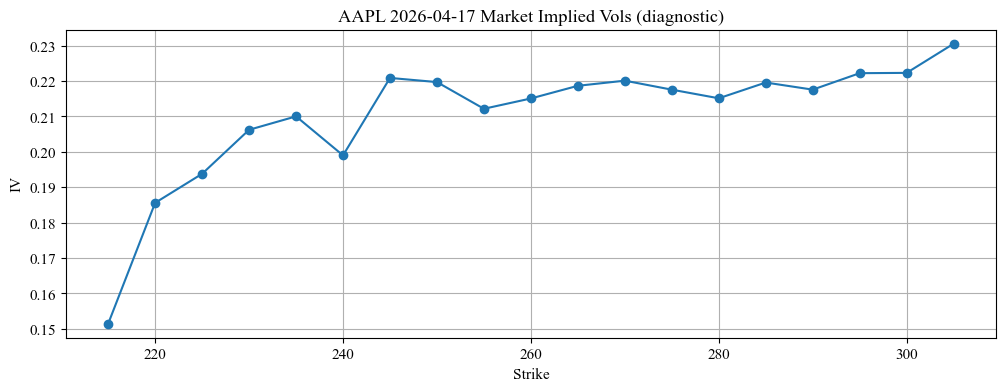

In [31]:
# === Real AAPL smile via yfinance, robust expiry selection ===
import numpy as np
import pandas as pd
import datetime as dt
import math
import yfinance as yf
import matplotlib.pyplot as plt

ticker = "AAPL"

# --- pick an expiry automatically: nearest to a target tenor (days) ---
target_tenor_days = 180  # ~6 months; change as you like

tk = yf.Ticker(ticker)
spot_hist = tk.history(period="1d")
if spot_hist.empty:
    raise RuntimeError("No spot data. Try a different period or check internet.")
S0 = float(spot_hist["Close"].iloc[-1])

# list available expirations and choose one
expiries = tk.options  # list of 'YYYY-MM-DD'
if not expiries:
    raise RuntimeError("No option expirations returned by yfinance.")
print("Available expiries:", expiries[:10], "...")

today = dt.date.today()
target_date = today + dt.timedelta(days=target_tenor_days)
# pick expiry with minimum absolute distance to target_date
expiry = min(expiries, key=lambda s: abs(dt.datetime.strptime(s,"%Y-%m-%d").date() - target_date))
print("Chosen expiry:", expiry)

# --- fetch chain & build mids ---
chain = tk.option_chain(expiry)
calls = chain.calls.copy()
puts  = chain.puts.copy()

def _mid(df):
    bid = pd.to_numeric(df["bid"], errors="coerce")
    ask = pd.to_numeric(df["ask"], errors="coerce")
    last= pd.to_numeric(df.get("lastPrice", np.nan), errors="coerce")
    mid = 0.5*(bid+ask)
    bad = ~np.isfinite(mid) | (mid <= 0)
    mid[bad] = last[bad]
    return mid

calls["mid"] = _mid(calls)
puts["mid"]  = _mid(puts)

tab = pd.merge(
    calls[["strike","mid"]].rename(columns={"mid":"Cmid"}),
    puts[["strike","mid"]].rename(columns={"mid":"Pmid"}),
    on="strike", how="inner"
).dropna(subset=["strike","Cmid","Pmid"])

# keep strikes near spot, thin if needed
moneyness_window = 0.25
tab = tab[(tab["strike"] > (1-moneyness_window)*S0) & (tab["strike"] < (1+moneyness_window)*S0)]
tab = tab.sort_values("strike").reset_index(drop=True)
if len(tab) > 30:
    tab = tab.iloc[::2].reset_index(drop=True)

if len(tab) < 5:
    raise RuntimeError(f"Too few strikes after cleaning: {len(tab)}. Try widening moneyness_window.")

strikes = tab["strike"].to_numpy(float)
C_mid   = tab["Cmid"].to_numpy(float)
P_mid   = tab["Pmid"].to_numpy(float)

# --- year fraction (ACT/365F) ---
expiry_d = dt.datetime.strptime(expiry, "%Y-%m-%d").date()
T = max(1e-6, (expiry_d - today).days / 365.0)

# --- infer DF, F, r, q via put–call parity regression: C - P = DF*(F - K) ---
y = C_mid - P_mid
X = np.vstack([np.ones_like(strikes), strikes]).T
beta, *_ = np.linalg.lstsq(X, y, rcond=None)
a, b = float(beta[0]), float(beta[1])
DF = max(1e-8, -b)
F  = a / DF
r  = -math.log(DF) / T
q  = r - math.log(F / S0) / T
print(f"S0={S0:.4f}, T={T:.4f}y, DF={DF:.6f}, r={r:.4%}, F={F:.4f}, q={q:.4%}")

# --- build smile for calibrators (use call mids; parity-cleaning is optional) ---
mids = C_mid.copy()
cp = "call"
smiles = [(S0, r, q, T, strikes, mids, cp)]

# --- diagnostics: plot prices & market IVs ---
plt.figure()
plt.plot(strikes, mids, marker="o")
plt.title(f"{ticker} {expiry} Call Mid Prices")
plt.xlabel("Strike"); plt.ylabel("Price"); plt.grid(True); plt.show()

# your helper from earlier
def implied_vol_q(price, S, K, T, r, q, option_type="call"):
    Seff = S * math.exp(-q*T)
    reff = r - q
    from src.volatility import implied_volatility
    return implied_volatility(price, Seff, K, T, reff, option_type=option_type)

def prices_to_ivs(S, r, q, T, strikes, prices, option_type="call"):
    ivs = []
    for K, p in zip(strikes, prices):
        try:
            ivs.append(implied_vol_q(p, S, K, T, r, q, option_type))
        except Exception:
            ivs.append(np.nan)
    return np.array(ivs, float)

mkt_iv = prices_to_ivs(S0, r, q, T, strikes, mids, option_type=cp)
plt.figure()
plt.plot(strikes, mkt_iv, marker="o")
plt.title(f"{ticker} {expiry} Market Implied Vols (diagnostic)")
plt.xlabel("Strike"); plt.ylabel("IV"); plt.grid(True); plt.show()


##  Calibration

*Settings:*
- **Metric:** Price
- **Vega-weighted:** Yes
- **MC controls:** adjust `paths` / `N` as needed
- **Multistart:** a few random starts around `x0` improves robustness

*Params estimated:* `(H, eta, rho, xi0)`


In [32]:
# --- rBergomi calibration (cached) ---
rb_cfg = dict(N=192, paths=20000, fgn_method="davies-harte", batch_size=4096, n_workers=WORKERS)
rb_x0  = (0.12, 1.4, -0.6, 0.04)
RB_BOUNDS = ((0.02, 0.45), (0.10, 3.00), (-0.999, 0.0), (0.005, 0.25))  # (H,eta,rho,xi0)
best_rb, rb_blob = calibrate_rbergomi_cached(
    smiles, metric="price", vega_weight=True, x0=rb_x0, mc=rb_cfg,bounds=RB_BOUNDS,
    seed=1234, multistart=3, options={"maxiter":150}
)
print("rBergomi best:", best_rb, "| elapsed:", rb_blob["elapsed_sec"])

# --- Rough Heston calibration (cached) ---
rh_cfg = dict(N=192, paths=20000, batch_size=4096, n_workers=WORKERS, use_numba=True)
rh_x0  = (0.06, 1.2, 0.06, 0.6, -0.2, 0.15)  # (v0, kappa, theta, eta, rho, H)
rh_bounds = ((0.01,0.20),(0.4,3.0),(0.01,0.20),(0.1,1.0),(-0.5,0.1),(0.08,0.30))
best_rh, rh_blob = calibrate_rough_heston_cached(
    smiles, metric="price", vega_weight=False, x0=rh_x0, mc=rh_cfg, seed=7777,
    bounds=rh_bounds, multistart=3, options={"maxiter":150}
)
print("Rough Heston best:", best_rh, "| elapsed:", rh_blob["elapsed_sec"])


[rBergomi #1 start #1] iter=0
[rBergomi #1] iter=1  f=299.749687  df=nan  |dx|=nan  3.54s
[rBergomi #1] iter=2  f=35.627723  df=-2.64e+02  |dx|=1.88e-01  1.60s
[rBergomi #1] iter=3  f=24.488942  df=-1.11e+01  |dx|=5.44e-02  1.57s
[rBergomi #1] iter=4  f=24.116575  df=-3.72e-01  |dx|=7.86e-03  1.60s
[rBergomi #1] iter=5  f=24.111897  df=-4.68e-03  |dx|=8.17e-04  1.62s
[rBergomi #1] iter=6  f=24.069263  df=-4.26e-02  |dx|=8.96e-03  1.59s
[rBergomi #1] iter=7  f=23.994450  df=-7.48e-02  |dx|=1.77e-02  1.59s
[rBergomi #1] iter=8  f=23.828755  df=-1.66e-01  |dx|=4.34e-02  1.67s
[rBergomi #1] iter=9  f=23.602892  df=-2.26e-01  |dx|=7.38e-02  1.64s
[rBergomi #1] iter=10  f=23.368702  df=-2.34e-01  |dx|=3.26e-02  1.73s
[rBergomi #1] iter=11  f=23.148969  df=-2.20e-01  |dx|=4.11e-02  1.94s
[rBergomi #1] iter=12  f=23.144337  df=-4.63e-03  |dx|=8.37e-03  2.01s
[rBergomi #1] iter=13  f=23.143841  df=-4.96e-04  |dx|=1.92e-03  1.80s
[rBergomi #1] iter=14  f=23.143391  df=-4.50e-04  |dx|=3.21e-03  1

## rBergomi: Model vs Market (Prices & IVs)

*We simulate once per maturity using the calibrated parameters, then price the whole smile.*


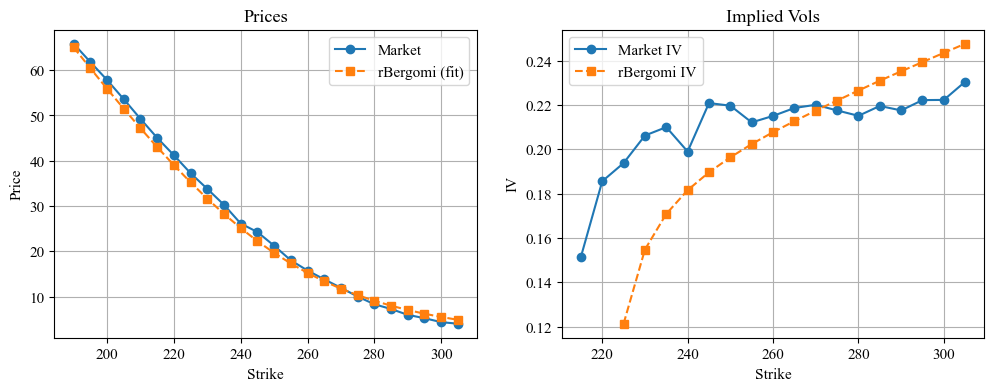

rBergomi IV RMSE: 0.02775078307558668


In [33]:
# --- rBergomi curves (robust to missing rb_blob / rb_cfg) ---

# 1) Resolve MC config with safe fallbacks
mc_cfg = {"N": 192, "paths": 12000, "fgn_method": "davies-harte"}  # defaults
seed_plot = 12345                                                   # default plotting seed

if "rb_cfg" in globals() and isinstance(rb_cfg, dict):
    mc_cfg.update(rb_cfg)

if "rb_blob" in globals() and isinstance(rb_blob, dict) and "cfg" in rb_blob and "mc" in rb_blob["cfg"]:
    mc_cfg.update(rb_blob["cfg"]["mc"])
    seed_plot = rb_blob["cfg"].get("seed", seed_plot)

N_rb = int(mc_cfg["N"])
P_rb = int(mc_cfg["paths"])
FGN  = mc_cfg.get("fgn_method", "davies-harte")

# 2) Fitted params must exist
H, eta, rho, xi0 = best_rb["H"], best_rb["eta"], best_rb["rho"], best_rb["xi0"]

# 3) Simulate & price
t, S_paths, _ = rbergomi_paths(
    S0=S0, T=T, N=N_rb, n_paths=P_rb,
    H=H, eta=eta, rho=rho, xi0=xi0,
    r=r, q=q, seed=seed_plot, fgn_method=FGN
)
ST = S_paths[:, -1]
DF = math.exp(-r * T)
model_prices_rb = np.array([np.mean(DF * np.maximum(ST - K, 0.0)) for K in strikes])
model_ivs_rb    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rb, option_type=cp)

# 4) Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rb, "s--", label="rBergomi (fit)")
ax[0].set_title("Prices"); ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()
ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rb, "s--", label="rBergomi IV")
ax[1].set_title("Implied Vols"); ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()
plt.show()

# 5) Diagnostics
iv_resid_rb = model_ivs_rb - mkt_iv
iv_rmse_rb  = float(np.sqrt(np.nanmean(iv_resid_rb**2)))
print("rBergomi IV RMSE:", iv_rmse_rb)


## Rough Heston Calibration (Price-space)
*Why price-space?* It avoids calling IV inversion inside the objective and is often more stable.

**Optional:** Add a soft **ATM** and/or **skew** penalty in your `calibration_rough.py` objective if your market smile is near-flat.  
(*See the comments in our earlier discussion for the exact snippet to add in `_rough_heston_objective`.*)


In [34]:
# MC controls; bump paths for a smoother objective, increase batch_size to heat up BLAS
rh_cfg = dict(N=192, paths=10000, batch_size=1024, n_workers=WORKERS, use_numba=True)

# Initial guess and bounds that discourage very heavy skew (tune to your market)
rh_x0 = (0.06, 1.2, 0.06, 0.6, -0.2, 0.15)  # (v0,kappa,theta,eta,rho,H)
rh_bounds = (
    (0.01, 0.20),   # v0
    (0.4,  3.0),    # kappa
    (0.01, 0.20),   # theta
    (0.1,  1.0),    # eta
    (-0.5, 0.1),    # rho
    (0.08, 0.30),   # H
)

# Rough Heston (cached)
best_rh, rh_blob = calibrate_rough_heston_cached(
    smiles,
    metric="price",
    vega_weight=False,
    x0=rh_x0,
    mc=rh_cfg,
    seed=7777,
    bounds=rh_bounds,
    multistart=3,
    options={"maxiter": 150}
)
print(best_rh)
print("elapsed (first/cached):", rh_blob["elapsed_sec"])

print("Rough Heston best:", best_rh)


[RoughHeston #1 start #1] iter=0
[RoughHeston #1] iter=1  f=6.964393  df=nan  |dx|=nan  3.88s
[RoughHeston #1] iter=2  f=6.829812  df=-1.35e-01  |dx|=1.40e-02  3.40s
[RoughHeston #1] iter=3  f=6.795696  df=-3.41e-02  |dx|=2.48e-03  0.94s
[RoughHeston #1] iter=4  f=6.755594  df=-4.01e-02  |dx|=7.54e-04  0.77s
[RoughHeston #1] iter=5  f=6.598446  df=-1.57e-01  |dx|=6.39e-03  0.77s
[RoughHeston #1] iter=6  f=5.642896  df=-9.56e-01  |dx|=9.65e-02  2.46s
[RoughHeston #1 best] f=5.642896  iters=6  45.03s
[RoughHeston #2 start #2] iter=0
[RoughHeston #2] iter=1  f=74.548950  df=nan  |dx|=nan  9.48s
[RoughHeston #2] iter=2  f=74.543902  df=-5.05e-03  |dx|=1.04e-06  3.30s
[RoughHeston #2] iter=3  f=74.535692  df=-8.21e-03  |dx|=1.91e-07  5.71s
[RoughHeston #2] iter=4  f=74.542046  df=+6.35e-03  |dx|=8.38e-08  4.79s
[RoughHeston #2] iter=5  f=74.542490  df=+4.45e-04  |dx|=8.32e-09  7.35s
[RoughHeston #2 best] f=74.542490  iters=5  58.88s
[RoughHeston #3 start #3] iter=0
[RoughHeston #3] iter=1  

## Rough Heston: Model vs Market (Prices & IVs)

*We re-simulate at the fitted params and compare against the input smile.*


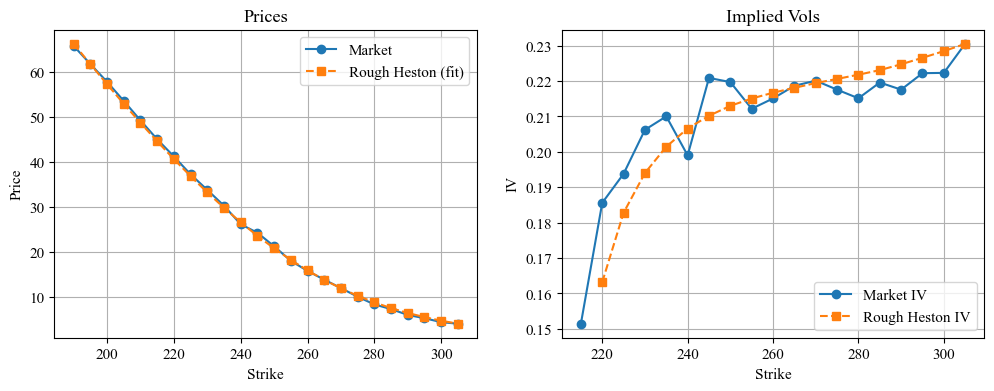

Rough Heston: IV RMSE: 0.008330970921363326  | Price RMSE: 0.41044575064685634


In [35]:
# --- Rough Heston curves: load from cache if available, else compute & save ---

# Build the cache key from the same config used for calibration
cache_path = rh_blob.get('cache_file')
if cache_path is None:
    cache_path = os.path.join(CACHE_DIR, 'rough_heston', 'manual_reload.json')
    json.dump(rh_blob, open(cache_path, 'w'))



p = best_rh
t, S_rh, V_rh = rough_heston_paths(
    S0=S0, v0=p["v0"], T=T, N=rh_cfg["N"], n_paths=rh_cfg["paths"],
    H=p["H"], kappa=p["kappa"], theta=p["theta"], eta=p["eta"], rho=p["rho"],
    r=r, q=q, seed=22222, batch_size=rh_cfg["batch_size"]
)
ST_rh = S_rh[:, -1]
DF = math.exp(-r * T)
model_prices_rh = np.array([np.mean(DF*np.maximum(ST_rh-K, 0.0)) for K in strikes])
model_ivs_rh    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rh, option_type=cp)


# Plot 
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rh, "s--", label="Rough Heston (fit)")
ax[0].set_title("Prices")
ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()

ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rh, "s--", label="Rough Heston IV")
ax[1].set_title("Implied Vols")
ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()

plt.show()

# 4) Diagnostics
iv_resid_rh = model_ivs_rh - mkt_iv
iv_rmse_rh  = float(np.sqrt(np.nanmean(iv_resid_rh**2)))
px_rmse_rh  = float(np.sqrt(np.mean((model_prices_rh - mids)**2)))
print("Rough Heston: IV RMSE:", iv_rmse_rh, " | Price RMSE:", px_rmse_rh)


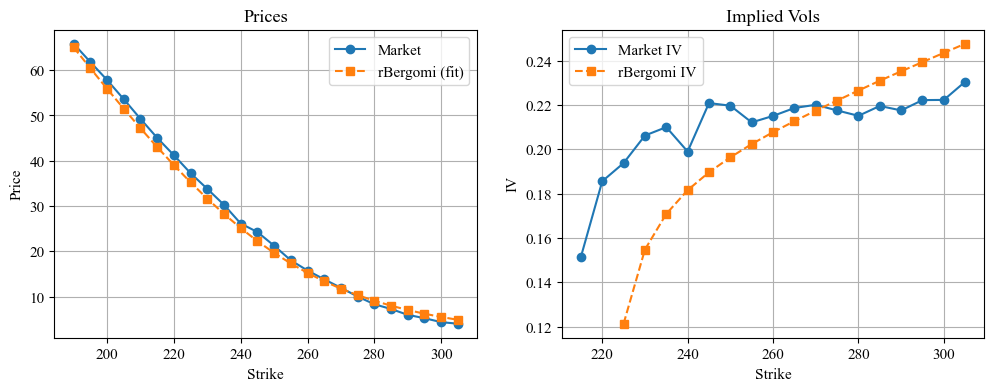

rBergomi IV RMSE: 0.02775078307558668


In [36]:
# ensure rBergomi curves exist (recompute if missing)
try:
    model_prices_rb, model_ivs_rb  # already computed?
except NameError:
    H, eta, rho, xi0 = best_rb["H"], best_rb["eta"], best_rb["rho"], best_rb["xi0"]
    t, S_paths, _ = rbergomi_paths(
        S0=S0, T=T, N=rb_cfg["N"], n_paths=rb_cfg["paths"],
        H=H, eta=eta, rho=rho, xi0=xi0, r=r, q=q,
        seed=12345, fgn_method=rb_cfg.get("fgn_method", "davies-harte")
    )
    ST = S_paths[:, -1]
    DF = math.exp(-r * T)
    model_prices_rb = np.array([np.mean(DF*np.maximum(ST - K, 0.0)) for K in strikes])
    model_ivs_rb    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rb, option_type=cp)

# plot + diagnostics (unchanged)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, model_prices_rb, "s--", label="rBergomi (fit)")
ax[0].set_title("Prices"); ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()
ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, model_ivs_rb, "s--", label="rBergomi IV")
ax[1].set_title("Implied Vols"); ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()
plt.show()

iv_resid_rb = model_ivs_rb - mkt_iv
iv_rmse_rb  = float(np.sqrt(np.nanmean(iv_resid_rb**2)))
print("rBergomi IV RMSE:", iv_rmse_rb)


## Optional: Two-Stage Calibration (Coarse → Refine)

*This procedure gets you close cheaply, then tightens with a richer MC budget.*


In [37]:
# --- Coarse stage ---
if 0:
    best_coarse, _ = calibrate_rough_heston(
        smiles,
        metric="price",
        vega_weight=False,
        x0=rh_x0,
        bounds=rh_bounds,
        parallel_backend=PAR_BACKEND, terminal_only=TERMINAL_ONLY,
        mc=dict(N=128, paths=4000, batch_size=2048),
        multistart=2,
        options={"maxiter": 80}
    )
    print("Coarse RH:", best_coarse)

    # --- Refine stage ---
    x0_ref = (best_coarse["v0"], best_coarse["kappa"], best_coarse["theta"],
            best_coarse["eta"], best_coarse["rho"], best_coarse["H"])

    best_refined, _ = calibrate_rough_heston(
        smiles,
        metric="price",
        vega_weight=False,
        x0=x0_ref,
        bounds=rh_bounds,
        parallel_backend=PAR_BACKEND, terminal_only=TERMINAL_ONLY,
        mc=dict(N=192, paths=16000, batch_size=4096),
        multistart=1,
        options={"maxiter": 150}
    )
    print("Refined RH:", best_refined)
    p = best_refined
    t, S_rh, V_rh = rough_heston_paths(
        S0=S0, v0=p["v0"], T=T, N=rh_cfg["N"], n_paths=rh_cfg["paths"],
        H=p["H"], kappa=p["kappa"], theta=p["theta"], eta=p["eta"], rho=p["rho"],
        r=r, q=q, seed=22222, batch_size=rh_cfg["batch_size"]
    )
    ST_rh = S_rh[:, -1]
    DF = math.exp(-r * T)
    model_prices_rh = np.array([np.mean(DF*np.maximum(ST_rh-K, 0.0)) for K in strikes])
    model_ivs_rh    = prices_to_ivs(S0, r, q, T, strikes, model_prices_rh, option_type=cp)

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(strikes, mids, "o-", label="Market")
    ax[0].plot(strikes, model_prices_rh, "s--", label="Rough Heston (fit)")
    ax[0].set_title("Prices")
    ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price"); ax[0].grid(True); ax[0].legend()

    ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
    ax[1].plot(strikes, model_ivs_rh, "s--", label="Rough Heston IV")
    ax[1].set_title("Implied Vols")
    ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV"); ax[1].grid(True); ax[1].legend()

    plt.show()

    # Diagnostics
    iv_resid_rh = model_ivs_rh - mkt_iv
    iv_rmse_rh  = float(np.sqrt(np.nanmean(iv_resid_rh**2)))
    px_rmse_rh  = float(np.sqrt(np.mean((model_prices_rh - mids)**2)))
    print("Rough Heston: IV RMSE:", iv_rmse_rh, " | Price RMSE:", px_rmse_rh)


## Robustness Tips

* Use **common random numbers** (seed per maturity) — already done in the calibration helpers.
* Add **antithetics** for both Gaussian streams (Z₁, Z₂) inside your path simulators to cut MC noise by ~2×.
* If the smile is **near-flat**, tighten bounds on ρ and η (weaker skew) and/or add a soft **ATM penalty** in the objective.
* For **multi-maturity** fits:
  - either calibrate each T separately first to seed a joint surface fit,
  - or parallelize per-maturity sims inside the objective.
* If IV inversion is fragile for extreme strikes, prefer **metric="price"**, and use vega-like weights in price space to emphasize ATM/near-ATM.


## Heston calibration (COS) in IV-space (vega-weighted)
### *We fit classic Heston to the same smile to compare against rBergomi & Rough Heston.*


In [38]:
from scipy.optimize import minimize, Bounds

def heston_smile_prices(S0, r, q, T, strikes, params, cp="call"):
    """
    params = (kappa, theta, v0, sigma, rho)
    Adapt ordering if your heston_price signature differs.
    """
    kappa, theta, v0, sigma, rho = params
    px = []
    for K in strikes:
        px.append(heston_price(S0=S0, K=K, T=T, r=r,
                               kappa=kappa, theta=theta, v0=v0, sigma=sigma, rho=rho,
                               q=q, option="call"))
    return np.array(px, dtype=float)

def heston_obj_iv(params, S0, r, q, T, strikes, mids, vega_weight=True):
    kappa, theta, v0, sigma, rho = params
    # stability guards
    if (kappa <= 0) or (theta <= 0) or (v0 <= 0) or (sigma <= 0) or not (-0.999 < rho < 0.999):
        return 1e6

    # model prices → model IV
    model_px = heston_smile_prices(S0, r, q, T, strikes, params, cp="call")
    mod_iv = prices_to_ivs(S0, r, q, T, strikes, model_px, option_type="call")
    mkt_iv = prices_to_ivs(S0, r, q, T, strikes, mids,     option_type="call")

    # valid mask
    mask = np.isfinite(mod_iv) & np.isfinite(mkt_iv)
    if mask.sum() == 0:
        return 1e6

    resid = (mod_iv - mkt_iv)[mask]

    if vega_weight:
        # compute vegas only where market IVs are finite
        ivs = mkt_iv
        valid = np.isfinite(ivs)
        vegas = np.zeros_like(strikes, dtype=float)

        eps = 1e-5
        idxs = np.where(valid)[0]              # indices where we can compute vega
        if idxs.size > 0:
            # finite-diff BS vega (your BS supports q)
            vals = []
            for i in idxs:
                K  = float(strikes[i])
                iv = float(max(ivs[i], 1e-6))
                p_plus  = black_scholes_price(S0, K, T, r, iv + eps, "call", q=q)
                p_minus = black_scholes_price(S0, K, T, r, max(iv - eps, 1e-6), "call", q=q)
                vals.append((p_plus - p_minus) / (2*eps))
            vegas[idxs] = np.array(vals, dtype=float)

        # normalize and apply only on the residual subset
        v_masked = vegas[mask]
        if np.all(v_masked == 0.0):
            w = 1.0
        else:
            scale = max(1e-8, np.percentile(v_masked[v_masked > 0], 75))  # robust scaling
            w = v_masked / scale
        resid = resid * w

    return float(resid @ resid)

# ---- run Heston calibration on the same smile ----
# rough x0 from ATM level
atm_idx = int(np.argmin(np.abs(strikes - S0)))
atm_iv  = float(mkt_iv[atm_idx]) if not np.isnan(mkt_iv[atm_idx]) else 0.25
x0_heston = np.array([1.5, max(1e-4, atm_iv**2), max(1e-4, atm_iv**2), 0.8, -0.5])  # (kappa,theta,v0,sigma,rho)
bnds_heston = Bounds([0.05, 1e-4, 1e-4, 0.05, -0.999],
                     [6.0,  1.0,  1.0,  3.0,   0.999])

obj = lambda p: heston_obj_iv(p, S0, r, q, T, strikes, mids, vega_weight=True)
res_heston = minimize(obj, x0=x0_heston, bounds=bnds_heston, method="L-BFGS-B", options={"maxiter": 200})
print("Heston best (kappa,theta,v0,sigma,rho):", res_heston.x)


Heston best (kappa,theta,v0,sigma,rho): [ 1.49207019  0.06062227  0.15554597  0.84300875 -0.65222901]


## Build model curves for all three models
### *We compute model prices & IVs so we can compare on the same plots.*


In [39]:
# --- Heston curves ---
params_h = tuple(res_heston.x)
px_h = heston_smile_prices(S0, r, q, T, strikes, params_h, cp="call")
iv_h = prices_to_ivs(S0, r, q, T, strikes, px_h, option_type="call")

# --- rBergomi curves (already simulated above as model_prices_rb / model_ivs_rb) ---
px_rb = model_prices_rb
iv_rb = model_ivs_rb

# --- Rough Heston curves (already simulated above as model_prices_rh / model_ivs_rh) ---
px_rh = model_prices_rh
iv_rh = model_ivs_rh


## Side-by-side comparison plots
### *Prices (left) and implied vols (right) for Market vs Heston vs rBergomi vs Rough Heston.*


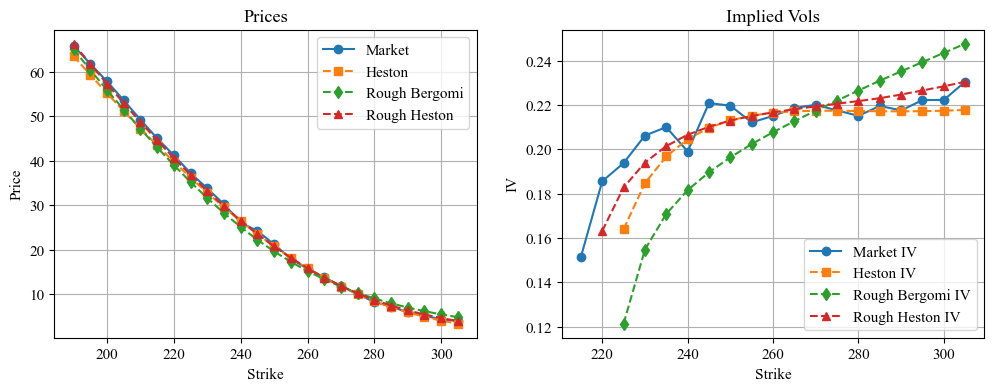

In [40]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Prices
ax[0].plot(strikes, mids, "o-", label="Market")
ax[0].plot(strikes, px_h, "s--", label="Heston")
ax[0].plot(strikes, px_rb, "d--", label="Rough Bergomi")
ax[0].plot(strikes, px_rh, "^--", label="Rough Heston")
ax[0].set_title("Prices"); ax[0].set_xlabel("Strike"); ax[0].set_ylabel("Price")
ax[0].grid(True); ax[0].legend()

# IVs
ax[1].plot(strikes, mkt_iv, "o-", label="Market IV")
ax[1].plot(strikes, iv_h,   "s--", label="Heston IV")
ax[1].plot(strikes, iv_rb,  "d--", label="Rough Bergomi IV")
ax[1].plot(strikes, iv_rh,  "^--", label="Rough Heston IV")
ax[1].set_title("Implied Vols"); ax[1].set_xlabel("Strike"); ax[1].set_ylabel("IV")
ax[1].grid(True); ax[1].legend()
plt.savefig("C:\\Users\\datog\\OneDrive\\Desktop\\options-pricing-library\\options-pricing-library\\notebooks\\cal.png", dpi=800, bbox_inches="tight", facecolor="white")
plt.show()


## RMSE summary (price & IV)
### *Quantify the fit quality across models on this smile.*


In [41]:
def rmse(a, b):
    a, b = np.asarray(a), np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))

price_rmse_h = rmse(px_h,  mids)
iv_rmse_h    = rmse(iv_h,  mkt_iv)
price_rmse_rb= rmse(px_rb, mids)
iv_rmse_rb   = rmse(iv_rb, mkt_iv)
price_rmse_rh= rmse(px_rh, mids)
iv_rmse_rh   = rmse(iv_rh, mkt_iv)

print("RMSE (Prices):   Heston={:.4f}  rBergomi={:.4f}  RoughHeston={:.4f}".format(
    price_rmse_h, price_rmse_rb, price_rmse_rh))
print("RMSE (IVs):      Heston={:.4f}  rBergomi={:.4f}  RoughHeston={:.4f}".format(
    iv_rmse_h, iv_rmse_rb, iv_rmse_rh))


RMSE (Prices):   Heston=1.2430  rBergomi=1.4527  RoughHeston=0.4104
RMSE (IVs):      Heston=0.0108  rBergomi=0.0278  RoughHeston=0.0083


In [42]:
kappa, theta, v0, sigma, rho_h = res_heston.x
print(f"Heston:     kappa={kappa:.3f}, theta={theta:.4f}, v0={v0:.4f}, sigma={sigma:.3f}, rho={rho_h:.3f}")

print(f"rBergomi:   H={best_rb['H']:.3f}, eta={best_rb['eta']:.3f}, rho={best_rb['rho']:.3f}, xi0={best_rb['xi0']:.4f}")

print("Rough Heston:",
      f"v0={best_rh['v0']:.4f}, kappa={best_rh['kappa']:.3f}, theta={best_rh['theta']:.4f}, "
      f"eta={best_rh['eta']:.3f}, rho={best_rh['rho']:.3f}, H={best_rh['H']:.3f}")


Heston:     kappa=1.492, theta=0.0606, v0=0.1555, sigma=0.843, rho=-0.652
rBergomi:   H=0.020, eta=1.201, rho=-0.680, xi0=0.0793
Rough Heston: v0=0.0848, kappa=0.820, theta=0.0368, eta=0.527, rho=-0.328, H=0.116
